LG AI hackathon Smart Factory
[대회 링크](https://dacon.io/competitions/official/236055/overview/description)

# Data Description

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


# MODULE IMPORT

In [425]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, f1_score

# warning message delete 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(37)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.Data Load

In [553]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [585]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

# 1.Pre-processing

## 1.1 EDA
1. `Y_Quality` and `X features`: 
    - NOT high correlation, yet  

In [313]:
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

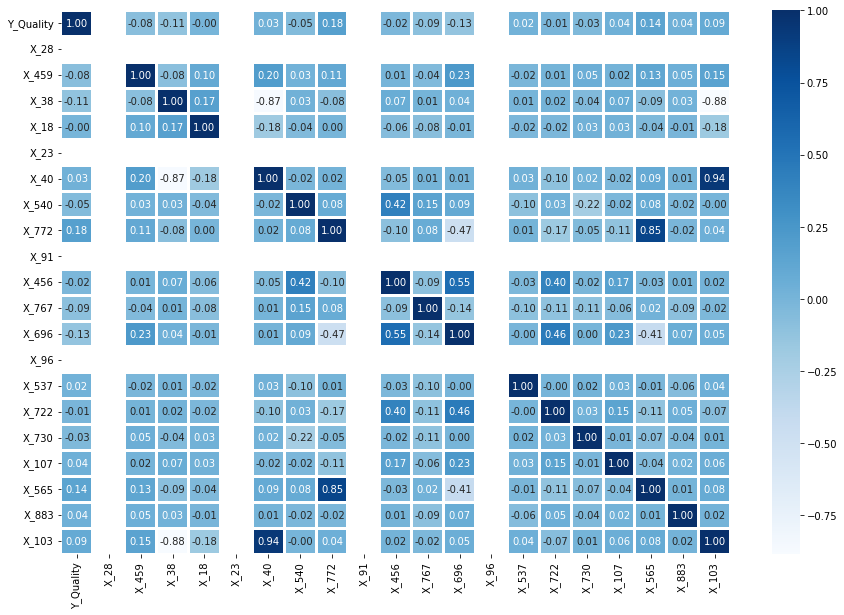

In [314]:
# heatmap: `random X features` and `Y_Quality` correlation 
import random
a = ['Y_Quality']

for i in range(20):
    num = random.randint(1,2875)
    a.append(cols_name[i])

corr = train_df[a].corr()  # correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

In [315]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,...,100.000000,100.00000,100.000000,100.000000,100.00000,99.0,0.0,0.0,0.0,0.0
mean,1.025084,0.530896,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,...,50.807300,53.60770,49.606200,51.659800,66.64970,1.0,NaN,NaN,NaN,NaN
std,0.565069,0.007401,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,...,7.011828,8.13899,7.158917,8.913065,4.52781,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,32.120000,31.70000,32.560000,30.490000,61.67000,1.0,NaN,NaN,NaN,NaN
25%,1.000000,0.527535,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,49.485000,52.20000,42.160000,49.915000,63.64500,1.0,NaN,NaN,NaN,NaN
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,53.425000,55.92500,51.460000,56.175000,65.14000,1.0,NaN,NaN,NaN,NaN
75%,1.000000,0.533433,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,...,55.287500,58.97500,55.030000,57.175000,67.11500,1.0,NaN,NaN,NaN,NaN
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,...,60.240000,68.66000,60.410000,59.930000,79.75000,1.0,NaN,NaN,NaN,NaN


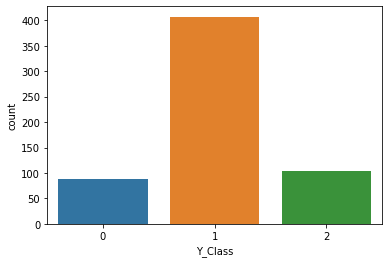

In [316]:
# UNBALANCED data --> metrics: precision, recall, f1-score 
sns.countplot(x='Y_Class', data=train_df);

## 1.2 Merge & Encoding
1. Merge `LINE` & `PRODUCT_CODE` & `Y_Class`columns by JOIN function
    - set the joined column name as `line_pcode_class`
2. Label encoding 
    - encode qualitative into quantitative

In [541]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,...,100.000000,100.00000,100.000000,100.000000,100.00000,99.0,0.0,0.0,0.0,0.0
mean,1.025084,0.530896,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,...,50.807300,53.60770,49.606200,51.659800,66.64970,1.0,NaN,NaN,NaN,NaN
std,0.565069,0.007401,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,...,7.011828,8.13899,7.158917,8.913065,4.52781,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,32.120000,31.70000,32.560000,30.490000,61.67000,1.0,NaN,NaN,NaN,NaN
25%,1.000000,0.527535,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,49.485000,52.20000,42.160000,49.915000,63.64500,1.0,NaN,NaN,NaN,NaN
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,53.425000,55.92500,51.460000,56.175000,65.14000,1.0,NaN,NaN,NaN,NaN
75%,1.000000,0.533433,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,...,55.287500,58.97500,55.030000,57.175000,67.11500,1.0,NaN,NaN,NaN,NaN
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,...,60.240000,68.66000,60.410000,59.930000,79.75000,1.0,NaN,NaN,NaN,NaN


In [555]:
# train_df['Y_Class'] = train_df['Y_Class'].astype(str)

col = ['LINE', 'PRODUCT_CODE']
train_df['line_pcode'] = train_df[col].apply(lambda row: ':'.join(row.values), axis=1)
train_df = train_df.drop(columns=['LINE', 'PRODUCT_CODE'])  

print(train_df['line_pcode'].value_counts())  

T100304:T_31    172
T100306:T_31    171
T050304:A_31     78
T010306:A_31     70
T010305:A_31     59
T050307:A_31     42
T100304:O_31      3
T100306:O_31      3
Name: line_pcode, dtype: int64


In [558]:
# Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['line_pcode']

for i in col:
    train_df[i] = encoder.fit_transform(train_df[i])

# correlation
# print(train_x[['Y_Quality', 'line_pcode']].corr()) 

In [559]:
train_df.line_pcode.unique()

array([2, 3, 5, 7, 1, 0, 4, 6])

In [545]:
# line_pcode & Y_Class  
# sns.countplot(train_df, col='Y_Class', hue='line_pcode');

# f = sns.FacetGrid(train_x, col="Y_Class")  
# f.map_dataframe(sns.histplot, x="line_pcode", binwidth=0.9);    

## 1.3 Missing Values
- [fill out NaN with Column's && Group's mean](https://rfriend.tistory.com/402) 

In [560]:
# 1) features that have only 'NaN' 
## Total 81 features only have 'NaN' 
miss_dic = train_df.isnull().sum().to_dict()
all_NaN = pd.DataFrame({i for i in miss_dic if miss_dic[i]==598})
all_NaN_name = list(all_NaN[0])  # all_NaN features name in list 
print(len(all_NaN_name))  

82


In [561]:
all_NaN2 = pd.DataFrame(np.zeros((82,82)), columns=list(all_NaN[0]))

for i in all_NaN_name: 
    train_df[i] = train_df[i].apply(lambda x: 0)
train_df.X_2686.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [562]:
train_df.isnull().sum().sum()

1123798

In [563]:
# 2) fill NaN with the feature's `line_pcde` grouped mean 
fill_group_mean = lambda g: g.fillna(g.mean())
train_df.groupby('line_pcode').apply(fill_group_mean)
train_df.isnull().sum().sum()

1123798

In [564]:
# 3) fillout remaining NaN with the feature's MEAN 
cols = train_df.iloc[:,2:].columns
for i in cols: 
    train_df[i].fillna(train_df[i].mean(), inplace=True)
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.00000,598.0,598.000000,598.000000,...,598.00000,598.000000,598.00000,598.00000,598.0,598.0,598.0,598.0,598.0,598.000000
mean,1.025084,0.530896,2.409742,95.123209,0.0,45.0,10.39255,0.0,48.802292,10.048711,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,4.078595
std,0.565069,0.007401,4.500960,3.136136,0.0,0.0,0.37336,0.0,3.339364,0.164586,...,3.31437,2.915263,3.62959,1.84382,0.0,0.0,0.0,0.0,0.0,2.471718
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.00000,0.0,45.000000,10.000000,...,31.70000,32.560000,30.49000,61.67000,1.0,0.0,0.0,0.0,0.0,0.000000
25%,1.000000,0.527535,2.000000,94.000000,0.0,45.0,10.00000,0.0,45.000000,10.000000,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,2.000000
50%,1.000000,0.530436,2.000000,95.123209,0.0,45.0,10.39255,0.0,48.802292,10.000000,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,5.000000
75%,1.000000,0.533433,2.409742,95.123209,0.0,45.0,10.39255,0.0,50.000000,10.048711,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,7.000000
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.00000,0.0,62.000000,11.000000,...,68.66000,60.410000,59.93000,79.75000,1.0,0.0,0.0,0.0,0.0,7.000000


In [565]:
# 4) check the remaining NULL 
miss_dic = train_df.isnull().sum().to_dict()
check = {i for i in miss_dic if miss_dic[i]>0}
check  # all_NaN features name in list   

set()

## 1.4 Scaling

[outlier Dection: IsolationForest](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)
- Standarization OR Normalization

### 1.4.1 Outliers

In [326]:
# outlier (replace 1Q, 3Q with MEDIAN)
# xs = list(train_df.iloc[:, 6:].columns)
# def outlier(df):
#     for col in xs: 
#         q1 = train_df[col].quantile(0.25)
#         q3 = train_df[col].quantile(0.75)
#         median = train_df[col].quantile(0.50)

#         train_df[col] = np.where(train_df[col]<q1, median, train_df[col])
#         train_df[col] = np.where(train_df[col]>q3, median, train_df[col])

# train_df 

## 1.5 Test_df Preprocessing

In [586]:
# Merge 
col = ['LINE', 'PRODUCT_CODE']
test_df['line_pcode'] = test_df[col].apply(lambda row: ':'.join(row.values), axis=1)
test_df = test_df.drop(columns=['LINE', 'PRODUCT_CODE'])

# Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['line_pcode']

for i in col:
    test_df[i] = encoder.fit_transform(test_df[i])

In [587]:
# Missing Values
# 1) features that have only 'NaN' without any recorded values 
## Total 506 features only have 'NaN' 
miss_dic = test_df.isnull().sum().to_dict()
all_nan = pd.DataFrame({i for i in miss_dic if miss_dic[i]==310})
all_nan_name = list(all_nan[0])  # all_NaN features name in list 

for i in all_nan_name: 
    test_df[i].fillna(0, inplace=True)
test_df.X_2277.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [589]:
print(len(test_df['line_pcode'].unique()))
print(test_df.isnull().sum().sum())

8
491347


In [590]:
# 2) fill NaN with the feature's `line_pcde` grouped mean 
fill_group_mean = lambda g: g.fillna(g.mean())
test_df.groupby('line_pcode').apply(fill_group_mean)
test_df.isnull().sum().sum()

491347

In [596]:
# 3) fillout remaining NaN with the feature's MEAN 
cols = test_df.iloc[:,:].columns
for i in cols: 
    test_df[i].fillna(test_df[i].mean(), inplace=True)
test_df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,310.000000,310.000000,310.0,310.0,310.000000,310.0,310.000000,310.000000,310.000000,310.0,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,4.337449,94.448560,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.138710
std,14.711941,3.595263,0.0,0.0,0.394436,0.0,3.303768,0.097923,9.276526,0.0,...,1.448128,1.998771,1.117486,0.628799,0.056154,4.097781,3.230763,5.715889,3.139910,2.064522
min,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,41.630000,39.850000,47.820000,60.720000,0.000000,199.000000,214.600000,169.700000,191.900000,0.000000
25%,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.000000
50%,2.000000,94.448560,0.0,45.0,10.000000,0.0,48.485597,10.000000,42.407407,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.000000
75%,2.000000,96.000000,0.0,45.0,10.271605,0.0,50.000000,10.000000,52.000000,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,7.000000
max,154.000000,102.000000,0.0,45.0,11.000000,0.0,67.000000,11.000000,52.000000,2.0,...,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000,7.000000


In [597]:
# 4) check the remaining NULL 
miss_dic = test_df.isnull().sum().to_dict()
check = {i for i in miss_dic if miss_dic[i]>0}
check  # all_NaN features name in list   

set()

In [593]:
# outlier (replace 1Q, 3Q with MEDIAN)
xs = list(test_df.iloc[:, 6:].columns)
def outlier(df):
    for col in xs: 
        q1 = test_df[col].quantile(0.25)
        q3 = test_df[col].quantile(0.75)
        median = test_df[col].quantile(0.50)

        test_df[col] = np.where(test_df[col]>q3, median, test_df[col])

test_df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,243.000000,243.000000,310.0,310.0,310.000000,310.0,310.000000,310.000000,310.000000,310.0,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,4.337449,94.448560,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.138710
std,16.624229,4.062582,0.0,0.0,0.394436,0.0,3.303768,0.097923,9.276526,0.0,...,1.448128,1.998771,1.117486,0.628799,0.056154,4.097781,3.230763,5.715889,3.139910,2.064522
min,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,41.630000,39.850000,47.820000,60.720000,0.000000,199.000000,214.600000,169.700000,191.900000,0.000000
25%,2.000000,91.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.000000
50%,2.000000,95.000000,0.0,45.0,10.000000,0.0,48.485597,10.000000,42.407407,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.000000
75%,2.000000,97.000000,0.0,45.0,10.271605,0.0,50.000000,10.000000,52.000000,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,7.000000
max,154.000000,102.000000,0.0,45.0,11.000000,0.0,67.000000,11.000000,52.000000,2.0,...,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000,7.000000


# 2.Modeling_ML

In [427]:
train_df['Y_Class'] = train_df['Y_Class'].astype(float)
X_train = train_df.drop(columns=['Y_Class','Y_Quality'])
y_train = train_df['Y_Quality']

test_x = test_df

In [337]:
test_x.isnull().sum()

X_1           0
X_2           0
X_3           0
X_4           0
X_5           0
             ..
X_2872        0
X_2873        0
X_2874        0
X_2875        0
line_pcode    0
Length: 2876, dtype: int64

## Y_Quality 예측

In [338]:
from sklearn.ensemble import GradientBoostingRegressor   

RF = GradientBoostingRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [339]:
preds=RF.predict(test_x)  
print('Done.')

Done.


In [340]:
test_x['Y_Quality'] = preds
test_x  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode,Y_Quality
0,2.000000,94.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.529572
1,2.000000,93.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.526419
2,2.000000,95.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.527665
3,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,0,0.524745
4,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,1,0.532461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2.000000,91.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.529465
306,2.000000,96.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.527537
307,2.000000,91.00000,0.0,45.0,10.000000,0.0,50.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.529178
308,2.000000,95.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.529647


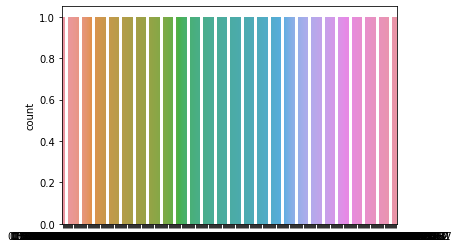

In [341]:
sns.countplot(x=preds);

## 다시 Y_Class 예측

In [342]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [343]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [344]:
from sklearn.ensemble import GradientBoostingClassifier

RF =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [345]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality']

In [346]:
test_x = pd.DataFrame(test_x)

preds = RF.predict(test_x)  
print('Done.')   

Done.


In [347]:
preds

array(['1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '2',
       '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '0',
       '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '1', '1',
       '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

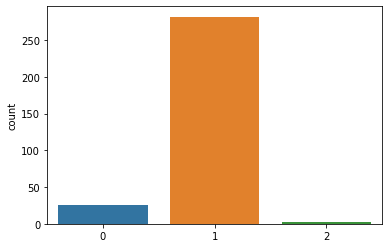

In [348]:
sns.countplot(x=preds, order=['0','1','2']);

## 2.1 Random Forest

In [129]:
X = train_df.drop(columns=['Y_Quality', 'Y_Class'])
y = train_df[['Y_Quality']]

In [130]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=37)

In [131]:
y_train

,Y_Quality
48,0.533273
72,0.538095
494,0.534827
30,0.528646
32,0.548592
...,...
451,0.530294
22,0.517719
437,0.526906
251,0.529097


In [132]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators = 10,
                                            oob_score=False)
RF_fitted = RF_model.fit(X_train, y_train)
preds = tf.cast(RF_fitted.predict(X_test) > 0.5, 
                     dtype = tf.float32)

# print('Accuracy = ', accuracy_score(RF_predict, y_test))
# print("Test Report = \n", classification_report(RF_predict, y_test))

<ipython-input-132-8cbca3e2ef17>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_fitted = RF_model.fit(X_train, y_train)


In [133]:
print(RF_fitted.score(X_train, y_train))
print(RF_fitted.score(X_test, y_test))

0.908770671112057
0.4940122172033936


In [154]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [155]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [156]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [157]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality']

In [158]:
test_x.isnull().sum()

Y_Quality    0
dtype: int64

In [159]:
preds = GBC_model.predict(test_x)  
print('Done.')   

Done.


In [160]:
preds

array(['1', '1', '1', '0', '0', '0', '0', '2', '2', '0', '0', '0', '0',
       '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '0', '0',
       '0', '0', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '2', '2', '2', '1', '1', '1', '1', '1', '1', '2', '1', '1', '2',
       '2', '2', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1',
       '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

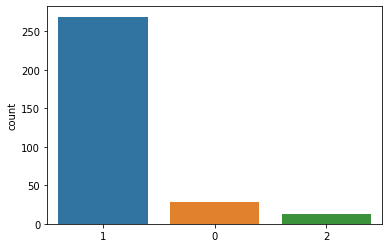

In [161]:
sns.countplot(x=preds, order=['0','1','2']);

# 3.Modeling_DL

# 4.Model Comparison

# 5.Inference
- finally, performs perdiction for test set

In [ ]:
test_x.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,4.121721,74.757204,0.721721,35.995914,8.773334,0.721721,38.728172,8.570108,33.963656,2.289463,...,5.979528,5.648270,6.109786,7.163109,0.201613,7.805342,7.918567,7.669213,7.249535,5.138710
std,14.760337,37.749826,1.775472,17.211959,3.095255,1.775472,18.936568,2.972388,18.620747,1.249758,...,16.614796,15.734697,16.959788,19.936360,0.389399,41.834183,42.411567,41.243141,38.544468,2.064522
min,0.850000,0.850000,0.000000,0.850000,0.850000,0.000000,0.850000,0.850000,0.850000,0.850000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,87.250000,0.000000,45.000000,10.000000,0.000000,45.000000,10.000000,31.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,2.000000,93.000000,0.000000,45.000000,10.000000,0.000000,45.000000,10.000000,31.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,2.000000,96.000000,0.000000,45.000000,10.000000,0.000000,50.000000,10.000000,52.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,154.000000,102.000000,7.330645,45.000000,11.000000,7.330645,67.000000,11.000000,52.000000,7.330645,...,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000,7.000000


In [ ]:
preds = RF_model.predict(test_x)
print('Done.')

Done.


In [ ]:
test_x['Y_Class']=preds
preds

array([2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1,
       0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

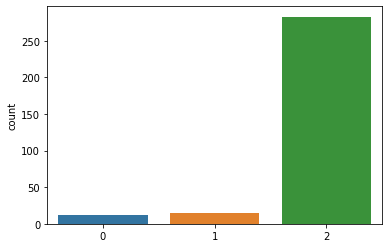

In [ ]:
sns.countplot(x=preds);

# 6.Submit

In [349]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission.csv', index=False)  

# THE END


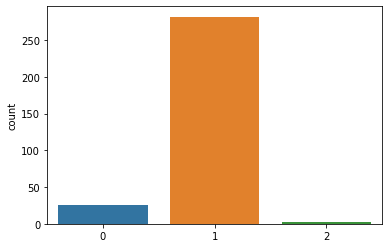

In [350]:
sns.countplot(x=preds, order=['0','1','2']);